In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# 5.1.1 畳み込み演算

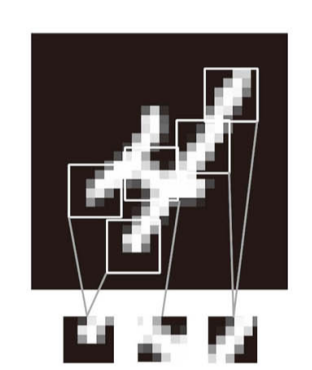

全結合層は入力特徴空間から大域的なパターンを学習する。畳み込み層は局所的なパターンを学習。    

- CNNが学習するパターンは移動不変    
画像の右下で特定のパターンを学習した場合は、画像のどの部分でもそのパターンを認識できる。資格の世界では根本的に移動不変。    
- CNNはパターンの空間階層を学習できる    
１つ目の畳み込み層はエッジといった小さい局所的パターンを学習し、２つ目の畳み込みはは１つ目の特徴量からなるより大きなパターンを学習するといった具合。

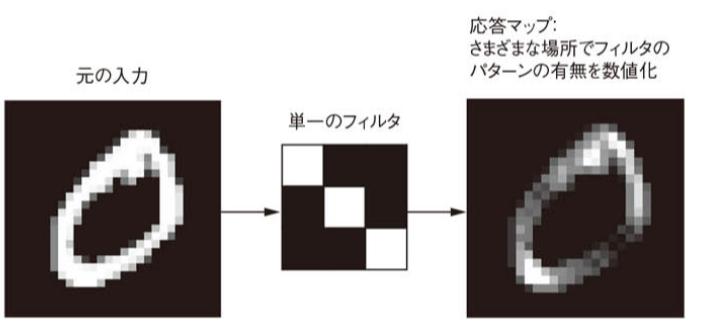

任意の特徴を取得できるフィルター。    
畳み込みの主なパラメータ。    

- 入力から抽出されたパッチのサイズ    
通常は3*3または5*5。    
- 出力特徴マップの深さ    
畳み込み演算されるフィルターの数。

- パディング    
余白を入れて出力サイズ等を調整    

kerasの場合はConv2Dにvalidを設定するとパディングなし。sameを設定すると出力の幅と高さが入力と同じになるようにパディングすること。デフォルトはvalid。    

- ストライド    
フィルターをずらす数    
フィルターの1個の要素をタイルって言ってる。つまりフィルターの中心タイルが連続してたが、1個飛ばしのタイルを中心にして計算したりする。ストライドが使用されることは希で、知っておいて損はないらしいが、どういう用途で使うのかは書いてない。max-poolingで使用される傾向にある。


- 出力サイズ計算例    


```
＠ゼロから作る参照

#縦横出力フィルター計算式
#OH: (H+2P-FH/S) + 1
#OW: (W+2P-FW/S) + 1
#H:入力縦幅#P:パディング#FH:フィルター縦幅#S:ストライド

#OH:(28+2・0-1/2)+1=14.5
branch_a = layers.Conv2D(128, 1, activation='relu', padding='same', strides=2, name="conv_a1")(x)

```




# 5.1.2 最大値プーリング演算

MaxPooling2Dを入れると出力サイズは半分になる。役割はダウンサンプリング。通常は2*2ウィンドウとストライド2の倍数で行う。畳み込みは大抵3*3ウィンドウとストライド１で構成される。    

畳み込みだけでいった場合を見てみる

In [3]:
from keras import layers
from keras import models

model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Flatten())
model_no_max_pool.add(layers.Dense(64, activation='relu'))
model_no_max_pool.add(layers.Dense(10, activation='softmax'))
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1982528   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 2,038,922
Trainable params: 2,038,922
Non-trainable params: 0
_________________________________________________________________


この設定の問題点    

- 特徴量の空間階層の学習に貢献しない    
３つ目の層の3*3ウィンドウに含まれるのは、最初の入力の7*7ウィンドウから得られた情報だけ。mnistは7*7サイズから数字が想定できるかもしれないが、もっと複雑な画像は細かくしないと捉えられないかもしれない。    
- 最終的な特徴マップが非常に大きい    
最終の平坦化で1280万個の係数になる。このような小さなモデルには大きすぎて、酷い過学習になるのは目に見えている。

実際に回してみる

In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model_no_max_pool.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_no_max_pool.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 20s 341us/step - loss: 0.1210 - acc: 0.9633
Epoch 2/5
60000/60000 [==============================] - 19s 319us/step - loss: 0.0396 - acc: 0.9879
Epoch 3/5
 5824/60000 [=>............................] - ETA: 16s - loss: 0.0194 - acc: 0.9938

60000/60000 [==============================] - 19s 315us/step - loss: 0.0270 - acc: 0.9920
Epoch 4/5
60000/60000 [==============================] - 19s 315us/step - loss: 0.0195 - acc: 0.9944
Epoch 5/5
12160/60000 [=====>........................] - ETA: 15s - loss: 0.0106 - acc: 0.9971

60000/60000 [==============================] - 19s 314us/step - loss: 0.0139 - acc: 0.9960


In [7]:
test_loss, test_acc = model_no_max_pool.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 2s 220us/step


0.991

99%の精度。。。　mnistでは過学習になってない。タスクが簡単すぎるのかな？

要するにダウンサンプリングを使用する理由は、処理の対象となる特徴マップの係数を減らすことと、連続する畳み込みが調べるウィンドウを徐々に大きくすることで、空間フィルタ階層を抽出することにある。    
ダウンサンプリングは畳み込みのストライドですることもできるし、average poolingを使用することもできる。averageよりmax poolingの方がうまくいく傾向にある。    
特徴量は特徴マップの様々なタイルに渡って何かしらのパターンの空間的に有無をエンコードする傾向にあるからです。　　
だから特徴マップと言われるのです。     
特徴量の平均プレゼンスを調べるより最大プレゼンスを調べる方が情報利得がある。

# 5.2 - 小さなデータセットでCNNを一から訓練する



## データをダウンロード

The cats vs. dogs dataset   
2013年kaggleコンペのデータ。    

`https://www.kaggle.com/c/dogs-vs-cats/data`

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

In [12]:
#下記リンクはそのうちdropboxから消すと思いますので。
!wget https://www.dropbox.com/s/bwl468kq78uac92/cat_dog_train.zip

--2018-06-16 00:22:27--  https://www.dropbox.com/s/bwl468kq78uac92/cat_dog_train.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc5c676340f8af9e047c052ca9c.dl.dropboxusercontent.com/cd/0/get/AI_pPcrudmSVDgSePbIF4g3hdSYbQVQEI5w6_-TBRJzeVzd4pNmGK0m8fXJLi46K_1lhQ2_BrL5ZrUYOAFRVYAc4ae8dWNabQbcWtOh5FCMSznrv1Hg3dE0ifkF6qXwYjnBypul80IXnntrBtxU32EM0monpzSKZl5daPb-Moxp3crd1VBtB1wCQk1EiWHqlYOA/file [following]
--2018-06-16 00:22:27--  https://ucc5c676340f8af9e047c052ca9c.dl.dropboxusercontent.com/cd/0/get/AI_pPcrudmSVDgSePbIF4g3hdSYbQVQEI5w6_-TBRJzeVzd4pNmGK0m8fXJLi46K_1lhQ2_BrL5ZrUYOAFRVYAc4ae8dWNabQbcWtOh5FCMSznrv1Hg3dE0ifkF6qXwYjnBypul80IXnntrBtxU32EM0monpzSKZl5daPb-Moxp3crd1VBtB1wCQk1EiWHqlYOA/file
Resolving ucc5c676340f8af9e047c052ca9c.dl.dropboxusercontent.com (ucc5c676340f8af9e047c052ca9c.dl.dropboxus

In [13]:
!ls

cat_dog_train.zip  datalab


In [0]:
# !unzip cat_dog_train.zip


In [36]:
!ls train | head -5


cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
ls: write error: Broken pipe


In [0]:
import os, shutil

In [0]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './train'

# The directory where we will
# store our smaller dataset
base_dir = './cats_and_dogs_small'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [29]:
!ls cats_and_dogs_small
!ls cats_and_dogs_small/train/dogs | head -2

!ls cats_and_dogs_small/train/cats | head -2

test  train  validation
dog.0.jpg
dog.100.jpg
cat.0.jpg
cat.100.jpg


As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [19]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [30]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [31]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [32]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [33]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [34]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


データができた。

## ネットワーク構築



In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

特徴マップの次元の変化を連続する層ごとに調べる

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## データの前処理

* 画像ファイルを読み込む
* JPEGファイルの内容をRGBのピクセルグリッドにデコード
* これらのピクセルを浮動小数点型のテンソルに変換
* ピクセル値(0〜255)の尺度を取り直し[0, 1]の範囲の値にする
    
keras.preprocessing.imageモジュールには画像処理ヘルパーツールがある。ImageDataGeneratorクラスでディスク上の画像ファイルを前処理されたテンソルのバッチに自動変換できる。

In [37]:
train_dir

'./cats_and_dogs_small/train'

In [38]:
ls ./cats_and_dogs_small/train

cats/  dogs/


In [39]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


ジェネレータの１つの形状はshape `(20, 150, 150, 3)`でラベルが(20,)。20の部分はバッチ。




In [40]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


fit_generatorを使って学習する。steps_per_epochの値になるまでジェネレータは無限にデータを生成する。steps_per_epochの値は自分で考えるぽい。20バッチで2000サンプルの場合は100回回せば全データ回るよね。

In [41]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30


ResourceExhaustedError: ignored

保存

In [0]:
model.save('cats_and_dogs_small_1.h5')

プロット

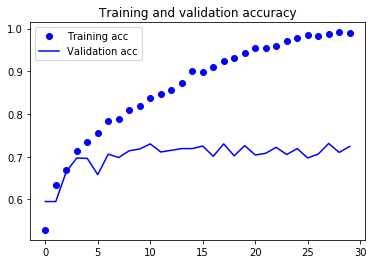

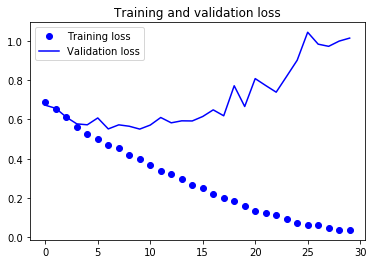

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

過学習してる。データ数が少ないことも起因。ドロップアウト、重み減衰(L2正則化)、などしてみると良い。データ拡張もよく使われる。

## データ拡張



In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

回転、平行移動、変形、ズーム、反転など

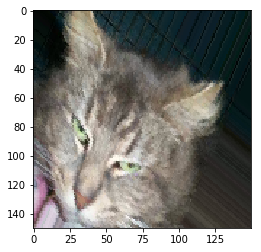

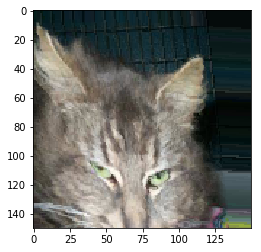

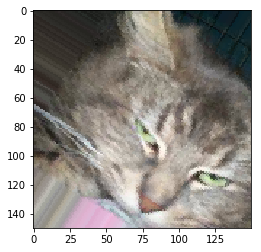

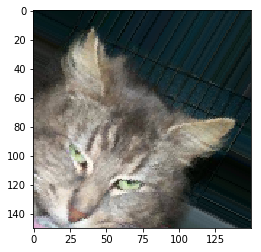

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

さらにdropoutも追加

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

データ拡張とドロップアウト

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 24s - loss: 0.6857 - acc: 0.5447 - val_loss: 0.6620 - val_acc: 0.5888
Epoch 2/100
100/100 [==============================] - 23s - loss: 0.6710 - acc: 0.5675 - val_loss: 0.6606 - val_acc: 0.5825
Epoch 3/100
100/100 [==============================] - 22s - loss: 0.6609 - acc: 0.5913 - val_loss: 0.6663 - val_acc: 0.5711.594 - ETA: 7s - loss: 0.6655 - ETA: 5s - los - ETA: 1s - loss: 0.6620 - acc: 
Epoch 4/100
100/100 [==============================] - 22s - loss: 0.6446 - acc: 0.6178 - val_loss: 0.6200 - val_acc: 0.6379
Epoch 5/100
100/100 [==============================] - 22s - loss: 0.6267 - acc: 0.6325 - val_loss: 0.6280 - val_acc: 0.5996
Epoch 6/100
100/100 [==============================] - 22s - loss: 0.6080 - acc: 0.6631 - val_loss: 0.6841 - val_acc: 0.5490
Epoch 7/100
100/100 [==============================] - 22s - loss: 0.5992 - acc: 0.6700 

保存

In [0]:
model.save('cats_and_dogs_small_2.h5')

再度プロット

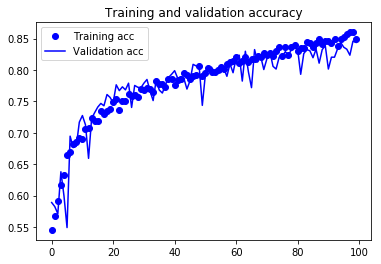

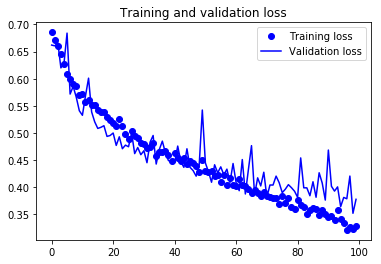

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

過学習が抑制された。